In [1]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
#from feature_engineering import add_retning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pandas as pd
import sys
from functools import partial
import optuna

sys.path.append('../data')

from display_data import import_data

In [2]:
def fix_missing_value(df):
    #layout, set everythin to 1
    df['layout'].fillna(int(1.0),inplace=True)



    #found correleation between number of stories and balconies,loggias
    df.loc[(df['stories'] < 7.0)&df['loggias'].isna(),'loggias'] = 0
    df.loc[(df['stories'] < 7.0)&df['balconies'].isna(),'balconies'] = 1

    df.loc[((df['stories'] > 12) & (df['stories'] < 16))|((df['stories'] > 17) & (df['stories'] < 24))&(df['loggias'].isna()),'loggias'] = 1
    df.loc[((df['stories'] > 12) & (df['stories'] < 16))|((df['stories'] > 17) & (df['stories'] < 24))&(df['loggias'].isna()),'balconies'] = 0


    #use the correleation between balconies and loggias to replace nans,
    df.loc[(df['loggias'] == 0.0 )& df['balconies'].isna(),'balconies'] = 1
    df.loc[(df['balconies'] == 0.0 )& df['loggias'].isna(),'loggias'] = 1
    df.loc[(df['loggias'] > 0.0 )& df['balconies'].isna(),'balconies'] = 0
    df.loc[(df['balconies'] > 0.0 )& df['loggias'].isna(),'loggias'] = 0

    #use correlation between material and ceiling groups
    ceiling_under_2 = len(df[((df['material'] == 4)|(df['material'] == 3)) & df['ceiling'].isna()])
    sample = df[df['ceiling'] < 2.6]['ceiling'].sample(n=ceiling_under_2,replace=True).to_numpy()
    df.loc[((df['material'] == 4)|(df['material'] == 3)) & (df['ceiling'].isna()),'ceiling'] = sample
    #use corelation between condition and ceiling groups
    ceiling_under_2 = len(df[(df['condition'] == 1) & df['ceiling'].isna()])
    sample = df[df['ceiling'] < 2.6]['ceiling'].sample(n=ceiling_under_2,replace=True).to_numpy()
    df.loc[(df['condition'] == 1) & df['ceiling'].isna(),'ceiling'] = sample


    #use correleation betwwen ceiling and area
    ceiling_over_3 = len(df[(df['area_total'] > 104)&(df['ceiling'].isna())])
    sample = df[df['ceiling'] > 3.0]['ceiling'].sample(n=ceiling_over_3,replace=True).to_numpy()
    df.loc[(df['area_total'] > 104)&(df['ceiling'].isna() ),'ceiling'] = sample

    ceiling_over_3 = len(df[(df['area_total'] > 75)&(df['ceiling'].isna())])
    sample = df[df['ceiling'] > 2.95]['ceiling'].sample(n=ceiling_over_3,replace=True).to_numpy()
    df.loc[(df['area_total'] > 75)&(df['ceiling'].isna() ),'ceiling'] = sample

    ceiling_under_2 = len(df[(df['area_total'] < 55)&(df['ceiling'].isna())])
    sample = df[df['ceiling'] < 2.8]['ceiling'].sample(n=ceiling_under_2,replace=True).to_numpy()
    df.loc[(df['area_total'] < 55)&(df['ceiling'].isna() ),'ceiling'] = sample

    #seller
    #use correleation between seller and new
    df.loc[(df['new'] == 1 )& df['seller'].isna(),'seller'] = 3

    #use correleation between seller and constructed
    df.loc[(df['constructed'] > 2018)& df['seller'].isna(),'seller'] = 3
    df.loc[(df['constructed'] < 1990)& df['seller'].isna(),'seller'] = 1

    #use correleation between seller and stories
    df.loc[(df['stories'] > 17)& df['seller'].isna(),'seller'] = 3
    df.loc[(df['stories'] < 9)& df['seller'].isna(),'seller'] = 1

    #use correleation between seller and district
    df.loc[((df['district'] == 3)|(df['district']==6))& df['seller'].isna(),'seller'] = 1
    df.loc[((df['district'] == 11)|(df['district']==2))& df['seller'].isna(),'seller'] = 3

    #conditon
    #use correleation between condition and new
    df.loc[(df['new'] == 1)& df['condition'].isna(),'condition'] = 0

    #use correleation between condition and constructed year
    df.loc[(df['constructed'] >= 2017)& df['condition'].isna(),'condition'] = 0
    df.loc[(df['constructed'] <= 1989)& df['condition'].isna(),'condition'] = 1

    #material
    #use correlation between material and district
    df.loc[(df['district'] == 3)& df['material'].isna(),'material'] = 3

    #use correleation between material and constructed year
    df.loc[((df['constructed'] > 1970)& (df['constructed'] <= 1989))&df['material'].isna(),'material'] = 3
    df.loc[(df['constructed'] <= 1970)&df['material'].isna(),'material'] = 0

    #use correleation between stories and material
    df.loc[(df['stories'] < 7)& df['material'].isna(),'material'] = 0
    df.loc[((df['stories'] > 7)&(df['stories'] < 9))& df['material'].isna(),'material'] = 3

    #use correleation between conditon and material
    df.loc[(df['condition'] == 3)& df['material'].isna(),'material'] = 3
    df.loc[(df['condition'] == 0)& df['material'].isna(),'material'] = 2

    #use correleation between parking and material
    df.loc[((df['parking'] == 3)|(df['parking'] == 2))& df['material'].isna(),'material'] = 2

    #user correlation between area and material
    df.loc[(df['area_total'] > 104)& df['material'].isna(),'material'] = 2

    #parking
    #use coreletion between parking and material
    df.loc[((df['material'] == 0)|(df['material'] == 3))& df['parking'].isna(),'parking'] = 1

    #use correleation between stories and parking
    df.loc[((df['stories'] > 30))& df['parking'].isna(),'parking'] = 0
    df.loc[((df['stories'] > 7)&(df['stories'] < 9))& df['parking'].isna(),'parking'] = 1

    #use correleation between radius and parking
    df.loc[(df['radius'] < 0.0547)& df['parking'].isna(),'parking'] = 0
    df.loc[(df['radius'] > 0.251)& df['parking'].isna(),'parking'] = 1

    #windows_court and windows_street
    #windows_street and balconies
    df.loc[(df['balconies'] == 2)& df['windows_street'].isna(),'windows_street'] = 1

    #windows street and area
    df.loc[(df['area_total'] > 106)& df['windows_street'].isna(),'windows_street'] = 1
    df.loc[(df['area_total'] < 47)& df['windows_street'].isna(),'windows_street'] = 0

    #windwos_street and stories
    df.loc[(df['stories'] > 40)& df['windows_street'].isna(),'windows_street'] = 1
    df.loc[(df['stories'] < 9)& df['windows_street'].isna(),'windows_street'] = 0

    #windows_street and windows_court
    df.loc[(df['windows_street'] == 0)& df['windows_court'].isna(),'windows_court'] = 1

    df.loc[((df['windows_street'] == 1)& (df['area_total'] > 75)) & df['windows_court'].isna(),'windows_court'] = 1
    df.loc[((df['windows_street'] == 1)& (df['area_total'] < 47)) & df['windows_court'].isna(),'windows_court'] = 0

    #balconies
    #balconies and stories
    df.loc[((df['stories'] >= 12)& (df['area_total'] <= 16)) & df['balconies'].isna(),'balconies'] = 0
    df.loc[(df['stories'] < 7) & df['balconies'].isna(),'balconies'] = 1
    df.loc[((df['stories'] > 17)& (df['area_total'] <= 24)) & df['balconies'].isna(),'balconies'] = 0

    #matrial and balconies
    df.loc[(df['material'] == 0) & df['balconies'].isna(),'balconies'] = 1
    df.loc[(df['material'] == 2) & df['balconies'].isna(),'balconies'] = 0

    #balconies and constructed
    df.loc[(df['constructed'] < 1970) & df['balconies'].isna(),'balconies'] = 1
    df.loc[(df['constructed'] > 2018) & df['balconies'].isna(),'balconies'] = 0

    #loggias
    #loggias and balconies
    df.loc[(df['balconies'] == 0) & df['loggias'].isna(),'loggias'] = 1
    df.loc[(df['balconies'] > 0) & df['loggias'].isna(),'loggias'] = 0

    #loggias and stories
    df.loc[(df['stories'] < 7) & df['loggias'].isna(),'loggias'] = 0
    df.loc[((df['stories'] >= 17)& (df['area_total'] <= 24)) & df['loggias'].isna(),'loggias'] = 1

    #bathrooms shared, bathroomes private

    #loggias and blaconies



    return df

def add_radius(df):
    #adds radius column to dataframe
    df['radius'] = np.sqrt((df['latitude']-55.75)**2 + (df['longitude']-37.55)**2)
    return df

def group_by_feature_and_price(df, feature, data_train = pd.DataFrame()):
    #makes a new column with the mean price for each group to all rows
    if data_train.empty:
        grouped = df.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price_y']
    else:
        grouped = data_train.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price']
    return df

def one_hot_encode(df, column_to_encode):
    """one hots encode for one singel column"""
    encoded_df = pd.get_dummies(df[[column_to_encode]].astype(str))
    df = pd.concat([df,encoded_df],axis=1)
    return df

def one_hot_encode_multiple(df, list_of_columns):
    """takes in multiple columns and runs one hot encode for each column"""
    for column_to_encode in list_of_columns:
        #print(column_to_encode)
        df = one_hot_encode(df, column_to_encode)
    return df

def add_direction(df):
    """adds direction to dataframe, can be one of eight categories (N,S,W,E)"""
    #straight up (north)
    normal_vector = np.array([0,1])
    #normal_vector = np.tile(normal_vector,(df.shape[0],1))
    #normal_vector = normal_vector.reshape((2,-df.shape[0]))
    temp = pd.DataFrame()
    temp['latitude'] = df['latitude']-55.75
    temp['longitude'] = df['longitude']-37.56


    apartment_vector = temp[['latitude','longitude']].to_numpy()


    #print(np.shape(apartment_vector), np.shape(normal_vector))
    angles = []
    for vector in apartment_vector:
        if vector[0] < 0:
            temp_angle = -angle_between(vector,normal_vector)
        else:
            temp_angle = angle_between(vector,normal_vector)
        angles.append(temp_angle)

    angles = [element * 10 for element in angles]


    angles_series = pd.Series(np.array(angles))
    #angles_series.plot.hist()

    df['angle'] = angles_series
    max = df.angle.max()
    min = df.angle.min()
    bins = [min,min*7/8,min*5/8,min*3/8,min/8,max/8,max*3/8,max*5/8,max*7/8,max]
    rounded_bins = [element for element in bins]
    #print(rounded_bins)
    direction = pd.cut(df.angle, bins= rounded_bins,labels=['S','SW','W','NW','N','NE','E','SE','S'],ordered=False)
    df['direction'] = direction
    return df

def unit_vector(vector):
    """returns the unit vector if the vector"""
    return vector/np.linalg.norm(vector)

def angle_between(v1,v2):
    """returns angle between two vectors in radian"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u,v2_u),-1,1))

def fix_geo_data(data_test):
    """should just be called on test data"""
    #fix all radius issues
    data_test._set_value(23,'longitude',37.473761)
    data_test._set_value(23,'latitude',55.560891)
    data_test._set_value(90,'longitude',37.473761)
    data_test._set_value(90,'latitude',55.560891)

    data_test._set_value(2511,'longitude',37.478055)
    data_test._set_value(2511,'latitude',55.544046)
    data_test._set_value(5090,'longitude',37.478055)
    data_test._set_value(5090,'latitude',55.544046)
    data_test._set_value(6959,'longitude',37.478055)
    data_test._set_value(6959,'latitude',55.544046)
    data_test._set_value(8596,'longitude',37.478055)
    data_test._set_value(8596,'latitude',55.544046)

    data_test._set_value(4719,'longitude',37.385493)
    data_test._set_value(4719,'latitude',55.853117)

    data_test._set_value(9547,'longitude',37.384711)
    data_test._set_value(9547,'latitude',55.853511)

    data_test._set_value(2529,'longitude',37.464994)
    data_test._set_value(2529,'latitude',55.627666)

    data_test = add_radius(data_test)

    return data_test

def drop_n_largest(data_train):
    """drops 4 largest values, should only be called on training set"""
    #drop 4 largest from training data, maybe not samrt, but we will see
    data_train.drop([3217,21414,15840,13938])
    return data_train

def clean_data(all_data):
    """cleans the data with all the knowledge we have so far"""


    #fix ceiling issues
    all_data.loc[all_data['ceiling'] > 50,'ceiling']*=0.01
    all_data.loc[all_data['ceiling'] > 25, 'ceiling']*=0.1
    all_data.loc[all_data['ceiling'] < 0.5,'ceiling'] = float('NaN')
    """"
    #fix area_kitchen and area_living issues
    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_total/all_data.area_kitchen

    all_data.loc[all_data['living'] > 1,'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['living'] > 1,'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    all_data.loc[all_data.area_living/all_data.area_total > 1, 'area_living'] = float('NaN')

    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_kitchen/all_data.area_total

    all_data['sum_area'] = all_data.area_living + all_data.area_kitchen
    all_data.loc[all_data['sum_area'] == 100, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 100, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    #this fixed some few rows.
    #when printing we see some other very clear "precentage situations, fixing these
    all_data.loc[all_data['sum_area'] == 38.5, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 38.5, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    """
    return all_data

def add_high_up(df):
    """add exponetital function to determine how high up a building is"""
    high_up = df.floor/df.stories
    high_up_exp = np.exp(high_up) - 1
    euler = np.exp(1)

    df['high_up'] = high_up_exp
    df['high_up'].where(df['high_up'] > euler, euler)


    return df

def log_radius(df):
    df['radius'] = np.log(df['radius'])
    return df

def cluster_geo_data(df,df_test):
    from sklearn.cluster import KMeans
    k_means = KMeans(n_clusters = 100, max_iter = 1000, init='k-means++')

    lat_long_pairs = df[['latitude','longitude']]
    lat_long_pairs_test = df_test[['latitude','longitude']]
    target_data = np.log(df.price)/np.log(15)

    k_means.fit(lat_long_pairs,sample_weight = target_data)
    df['cluster_number'] = k_means.predict(lat_long_pairs)
    df_test['cluster_number'] = k_means.predict(lat_long_pairs_test)

    return df, df_test

def rf_data_prep(data_rf,data_test_rf):
    Y = data_rf.price
    radius = True
    # Add radius
    if(radius):
        data_rf = add_radius(data_rf)
        data_test = add_radius(data_test_rf)
        #coordinates = ['latitude', 'longitude']
        #data = data.drop(columns = coordinates)
        #data_test = data_test.drop(columns = coordinates)


    data_rf = data_rf.drop(columns = ['area_living', 'area_kitchen'])
    data_test_rf = data_test_rf.drop(columns = ['area_living', 'area_kitchen'])

    categorical_data = ['seller','layout', 'windows_court', 'windows_street', 'condition', 'building_id','new','district','street',
                        'address', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']
    cleaning = True

    if(cleaning):
        data_test_rf = fix_radius(data_test_rf)
        data_rf = clean_data(data_rf)
        data_test_rf = clean_data(data_test_rf)

    data_columns_rf = list(data_rf.columns)
    numerical_data = list(set(data_columns_rf)-set(categorical_data))
    print(numerical_data)
    for column in numerical_data:
        mean = data_rf[column].mean()
        data_rf[column] = data_rf[column].replace(np.NaN, mean)
        if column != 'price':
            mean_test = data_test_rf[column].mean()
            data_test_rf[column] = data_test_rf[column].replace(np.NAN,mean)

    #Features
    radius = True
    district_mean_price = False #her er det nan
    ohe = True
    direction = True
    high_up = True
    #add high up


    if(high_up):
        data_rf = add_high_up(data_rf)
        data_test_rf = add_high_up(data_test_rf)

    if(district_mean_price):
        data_rf = group_by_feature_and_price(data_rf,'district')
        data_test_rf = group_by_feature_and_price(data_test_rf,'district',data_train=data_rf)
        data_rf = data_rf.drop(columns=['price', 'id'])


    if(direction):
        data_rf = add_direction(data_rf)
        data_test_rf = add_direction(data_test_rf)
        data_rf = one_hot_encode(data_rf, 'direction')
        data_test_rf = one_hot_encode(data_test_rf, 'direction')
        data_rf = data_rf.drop(columns = 'direction')
        data_test_rf = data_test_rf.drop(columns = 'direction')


    #One hot encode data
    if(ohe):
        encode_categorical_data_rf = ['seller','layout', 'windows_court', 'windows_street', 'condition','new','district',
                        'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']
        data_rf = one_hot_encode_multiple(data_rf,encode_categorical_data_rf)
        data_test_rf = one_hot_encode_multiple(data_test_rf,encode_categorical_data_rf)
    #####HER MÅ DET FIKSES 
    # skal man logtransformere`?
    #data_rf['price'] = np.log(data_rf['price'])/np.log(15)
    ### TROR IKKE MAN TRENGER SCALE
    #scaler = MinMaxScaler() # mapper alt til mellom 0 og 1, default
    #data_rf[numerical_data] = scaler.fit_transform(data_rf[numerical_data])
    #Y = scale(Y) ##FIKS her
    #Y = data_rf['price']
    data_rf = data_rf.drop(columns=['price', 'id'])

    #Drop cat_data
    data_rf = data_rf.drop(columns = categorical_data) # har one-hot encoda lengre oppe
    data_test_rf = data_test_rf.drop(columns=['id'])
    data_test_rf = data_test_rf.drop(columns = categorical_data) #må huske testdataen
    
    ## Rot under her

    nan_values = data_rf.isna().any()
    nan_columns = nan_values.any()


    columns_with_nan = data_rf.columns[nan_columns].tolist()
    #print(nan_values)
    #print(columns_with_nan)
    for column in data_rf.columns:
        if data_rf[column].isna().any():
            print(column)

    print(Y)
    if (Y.values < 0).any():
        print('Gunnar')
    return data_rf, data_test_rf

def fix_radius(data_test):
    """should just be called on test data"""
    #fix all radius issues
    data_test._set_value(23,'radius',0.203899)
    data_test._set_value(90,'radius',0.203899)
    data_test._set_value(2511,'radius',0.218159)
    data_test._set_value(5090,'radius',0.218159)
    data_test._set_value(6959,'radius',0.218159)
    data_test._set_value(8596,'radius',0.218159)
    data_test._set_value(4719, 'radius',0.19580)
    data_test._set_value(9547, 'radius',0.19520)
    data_test._set_value(2529, 'radius', np.sqrt((37.464994-37.55)**2+(55.627666-55.75)**2))

    return data_test

In [3]:
def optimize(trial, x, y):
    #criterion = trial.suggest_categorical("criterion", ["poisson", "entropy"])
    n_estimators = trial.suggest_int("n_estimators", 50,300)
    max_depth = trial.suggest_int("max_depth",3,100)
    min_samples_leaf = trial.suggest_int("min_samples_leaf",1,10)
    max_features = trial.suggest_uniform("max_features", 0.01,1.0)
    model = RandomForestRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features
    ) 
    kf = KFold(n_splits=5)
    accuracies = []
    count = 0
    for idx in kf.split(X=x,y=y):
        count += 1
        print(x.shape)
        print(y.shape)
        print("count: ", count)
        train_idx,test_idx = idx[0],idx[1]
        xtrain = x.iloc[train_idx]
        ytrain = y.iloc[train_idx]
        ytrain = np.log(ytrain)/np.log(15)

        #     x_train, x_test = x.iloc[list(train_index)], x.iloc[list(test_index)]

        xtest = x.iloc[test_idx]
        ytest = y.iloc[test_idx]

        model.fit(xtrain,ytrain)
        preds = model.predict(xtest)
        preds = 15**preds
        fold_acc = root_mean_squared_log_error(ytest,preds)
        accuracies.append(fold_acc)
    return np.mean(accuracies)
    

['stories', 'id', 'price', 'radius', 'loggias', 'bathrooms_private', 'rooms', 'latitude', 'area_total', 'ceiling', 'longitude', 'floor', 'balconies', 'constructed', 'bathrooms_shared', 'phones']


[I 2021-11-18 16:19:59,069] A new study created in memory with name: no-name-610b8bee-cf0b-4fdd-9246-3ad9f3d4c791


0         7139520.0
1        10500000.0
2         9019650.0
3        10500000.0
4        13900000.0
            ...    
23280    13300000.0
23281    15854300.0
23282    19800000.0
23283    29999000.0
23284    10950000.0
Name: price, Length: 23285, dtype: float64


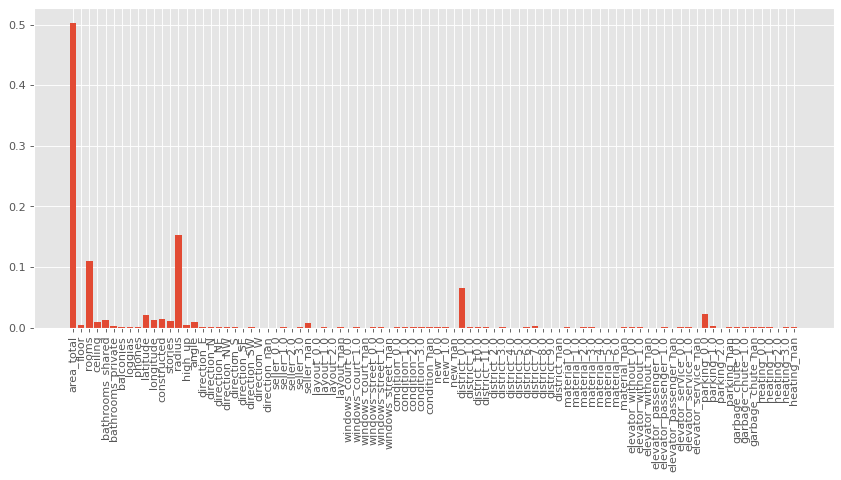

<class 'numpy.ndarray'>
4657
0
first run 0.15444425245396812


In [4]:
data_rf, data_test_rf = import_data()
Y = data_rf.price
test_id = data_test_rf.id

data_rf, data_test_rf = rf_data_prep(data_rf,data_test_rf)

X = data_rf

optimization_function = partial(optimize,x=X,y = Y)
study = optuna.create_study(direction = "minimize")
#study.optimize(optimization_function, n_trials = 15)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(data_rf, Y, test_size=0.2, random_state=42)

def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

#data.info()
#print(len(Y))
#print(data.corr())
kaggle = False
if(kaggle):
    rf_model = RandomForestRegressor(random_state = 42)
    Y = np.log(Y)/np.log(15)
    rf_model.fit(data_rf,Y)
    result_rf = rf_model.predict(data_test_rf)

    result_rf = 15**result_rf
    submission = pd.DataFrame()
    submission['id'] = test_id
    submission['price_prediction'] = result_rf
    submission.to_csv('submission_rf.csv', index= False)


    

else:
    #Trial 10 finished with value: 0.1565500591157633 and parameters: {'n_estimators': 299, 'max_depth':
    #  95, 'min_samples_leaf': 1, 'max_features': 0.40272028585103103}. Best is trial 10 with value: 0.1565500591157633.
    #y_train = np.log(y_train_rf)/np.log(15)
    rf_model = RandomForestRegressor( 
        random_state=42, 
        n_estimators=299, 
        max_depth = 95, 
        max_features=0.4027, 
        min_samples_leaf=1)
    y_train_rf = np.log(y_train_rf)/np.log(15)
    rf_model.fit(X_train_rf,y_train_rf)
    prediction = rf_model.predict(X_test_rf)
    prediction = 15**prediction

    features =rf_model.feature_names_in_
    importances = rf_model.feature_importances_ 
    fig = plt.figure(figsize=(10, 4), dpi=80)
    ax = fig.add_axes([0,0,1,1])
    ax.bar(features, importances)
    plt.xticks(rotation=90)
    plt.show()


    print(type(prediction))
    print(len(prediction))
    cunt = 0
    meanp = prediction.mean()
    for i, p in enumerate(prediction):
        if p < 0:
            cunt += 1
            prediction[i] = meanp
    print(cunt)


    #prediction = 15**prediction
    rmsle = root_mean_squared_log_error(y_test_rf,prediction)
    print("first run", rmsle)




default: 0.1611224356454586

random_state = 42: 0.1605 #bruker denne videre

max_depth = 8: 0.21726959429979462

n_estimators = 500: 0.15921634217100455

optuna: n_estimators = 83, max_depth = 35

Trial 10 finished with value: 0.1565500591157633 and parameters: {'n_estimators': 299, 'max_depth': 95, 'min_samples_leaf': 1, 'max_features': 0.40272028585103103}. Best is trial 10 with value: 0.1565500591157633.

Gunnar:
max_depth = 8
n_estimators 750
